<a href="https://colab.research.google.com/github/Leeseonggye/XAI_study/blob/main/%EC%8B%A0%EC%9A%A9%EB%8C%80%EC%B6%9C%EA%B0%80%EB%8A%A5%EC%97%AC%EB%B6%80_XGBoost_Shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
loan_data = pd.read_csv('/content/drive/MyDrive/XAI/XAI_dataset-master/Ch1.loan/loanData.csv')

In [5]:
loan_data[:3]

,id,gender,age,married,dependents,education,self_employed,business_type,applicant_income,applicant_work_period,coapplicant_income,credit_history,credit_amount,property_area,property_type,credit_rate,loan_amount,loan_term,loan_status
0,LA001250,Male,55,Yes,3+,Not Graduate,No,88,4755,51,0.0,0.0,0,Semiurban,3,8,2090,0,0
1,LA001864,Male,68,Yes,3+,Not Graduate,No,14,4931,47,0.0,NaN,0,Semiurban,3,7,5376,24,0
2,LA002536,Male,43,Yes,3+,Not Graduate,No,56,3095,33,0.0,1.0,1382,Rural,3,5,3390,33,1


In [9]:
loan_data.describe()

,age,business_type,applicant_income,applicant_work_period,coapplicant_income,credit_history,credit_amount,property_type,credit_rate,loan_amount,loan_term,loan_status
count,614.000000,614.000000,614.000000,614.000000,614.000000,564.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,39.553746,58.635179,5403.459283,44.812704,1621.245798,0.842199,2125.662866,1.908795,3.486971,4292.403909,28.656352,0.610749
std,12.440772,25.968367,6109.041673,16.885637,2926.248369,0.364878,1798.315927,0.824673,1.708531,2533.159379,8.773987,0.487978
min,17.000000,1.000000,150.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,198.000000,0.000000,0.000000
25%,30.000000,43.000000,2877.500000,33.000000,0.000000,1.000000,656.500000,1.000000,2.000000,2714.000000,24.000000,0.000000
50%,38.000000,61.000000,3812.500000,45.000000,1188.500000,1.000000,1948.500000,2.000000,3.000000,3670.000000,30.000000,1.000000
75%,47.000000,81.000000,5795.000000,59.000000,2297.250000,1.000000,3214.250000,3.000000,5.000000,5254.500000,36.000000,1.000000
max,75.000000,99.000000,81000.000000,72.000000,41667.000000,1.000000,7789.000000,3.000000,8.000000,19620.000000,53.000000,1.000000


In [11]:
loan_data.keys()

Index(['id', 'gender', 'age', 'married', 'dependents', 'education',
       'self_employed', 'business_type', 'applicant_income',
       'applicant_work_period', 'coapplicant_income', 'credit_history',
       'credit_amount', 'property_area', 'property_type', 'credit_rate',
       'loan_amount', 'loan_term', 'loan_status'],
      dtype='object')

In [23]:
for column in loan_data.keys():
  unique = loan_data[column].unique()
  if len(unique) > 10:
    print('%s : Too many' % column)
  else: print('%s : %s' % (column, unique))

id : Too many
gender : ['Male' 'Female' nan]
age : Too many
married : ['Yes' 'No' nan]
dependents : ['3+' '2' '1' '0' nan]
education : ['Not Graduate' 'Graduate']
self_employed : ['No' 'Yes' nan]
business_type : Too many
applicant_income : Too many
applicant_work_period : Too many
coapplicant_income : Too many
credit_history : [ 0. nan  1.]
credit_amount : Too many
property_area : ['Semiurban' 'Rural' 'Urban']
property_type : [3 2 1]
credit_rate : [8 7 5 4 3 2 1 6]
loan_amount : Too many
loan_term : Too many
loan_status : [0 1]


# Categorical data 전처리

In [26]:
gendr_mapping = {'Male': 1, 'Female': 0, np.nan: -1}
married_mapping = {'No': 0, 'Yes': 1, np.nan: -1}
dep_mapping = {'0': 0, '1': 1, '2': 2, '3+': 3, np.nan: -1}
edu_mappiong = {'Graduate': 1, 'Not Graduate': 0}
emp_mapping = {'No': 0, 'Yes': 1, np.nan: -1}
prop_mapping = {'Urban': 1, 'Rural': 3, 'Semiurban': 2}

loan_data = loan_data.replace({'gender': gendr_mapping,
                               'married': married_mapping,
                               'dependents': dep_mapping,
                               'education': edu_mappiong,
                               'self_employed': emp_mapping,
                               'property_area': prop_mapping
                              })

### Train/Test Split

In [27]:
# id 제외
X = loan_data.loc[:, 'gender':'loan_term']
y = loan_data.loc[:, 'loan_status']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

## Training

In [28]:
model = XGBClassifier()
model.fit(x_train, y_train)

from sklearn.metrics import accuracy_score

def calculate_accuracy(model, x_test, y_test):
    # make predictions
    y_pred = model.predict(x_test)
    predictions = [round(value) for value in y_pred]
    
    # evaluations
    accuracy = accuracy_score(y_test, predictions)
    print('Accuracy: %.2f%%' % (accuracy * 100.0))
    return accuracy

calculate_accuracy(model, x_test, y_test)

Accuracy: 84.55%


0.8455284552845529

In [31]:
model = XGBClassifier(
    booster='gbtree',
    objective='binary:logistic',
    learning_rate=0.04,
    n_estimators=50,
    reg_alpha =0.45,
    reg_lambda=0.6
)
model.fit(x_train, y_train)

print(model.evals_result)
calculate_accuracy(model, x_test, y_test)

<bound method XGBClassifier.evals_result of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.04, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.45, reg_lambda=0.6, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)>
Accuracy: 85.37%


0.8536585365853658

##XAI 적용

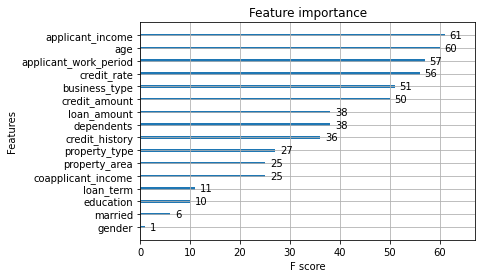

In [33]:
import xgboost
xgboost.plot_importance(model)

In [35]:
!pip install shap
import shap

     |████████████████████████████████| 358kB 6.1MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491621 sha256=6416e5d723d9bc132c6b3dc18ecaad1e5ef528f071067645a5cfff63ce422716
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [36]:
x_train.iloc[1, :]
idx = 13
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, 
                shap_values[idx,:], 
                x_train.iloc[idx,:])

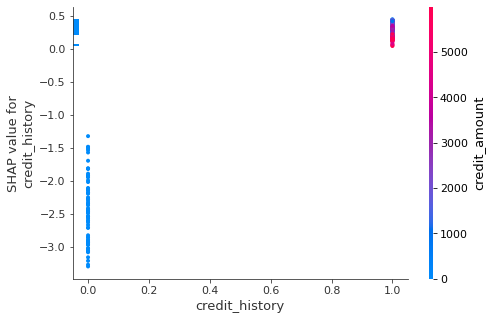

In [38]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("credit_history", shap_values, x_train)

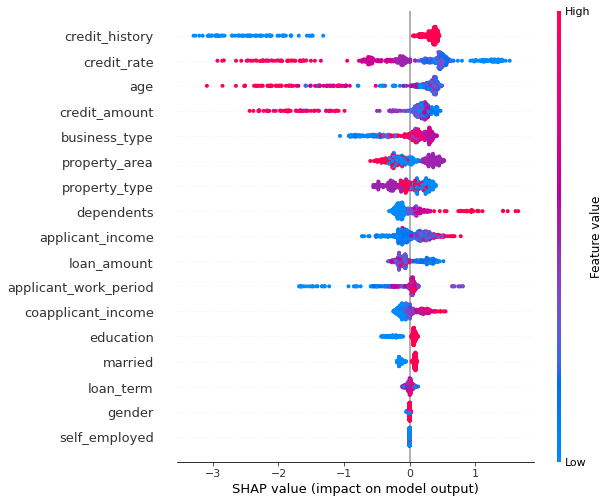

In [39]:
# summarize the effects of all the features
shap.summary_plot(shap_values, x_train)

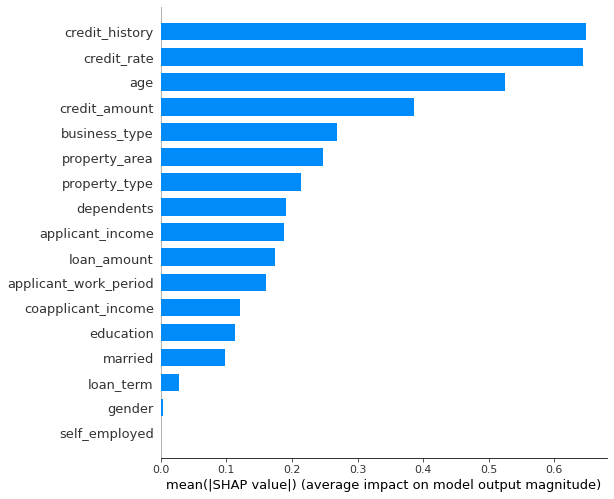

In [40]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

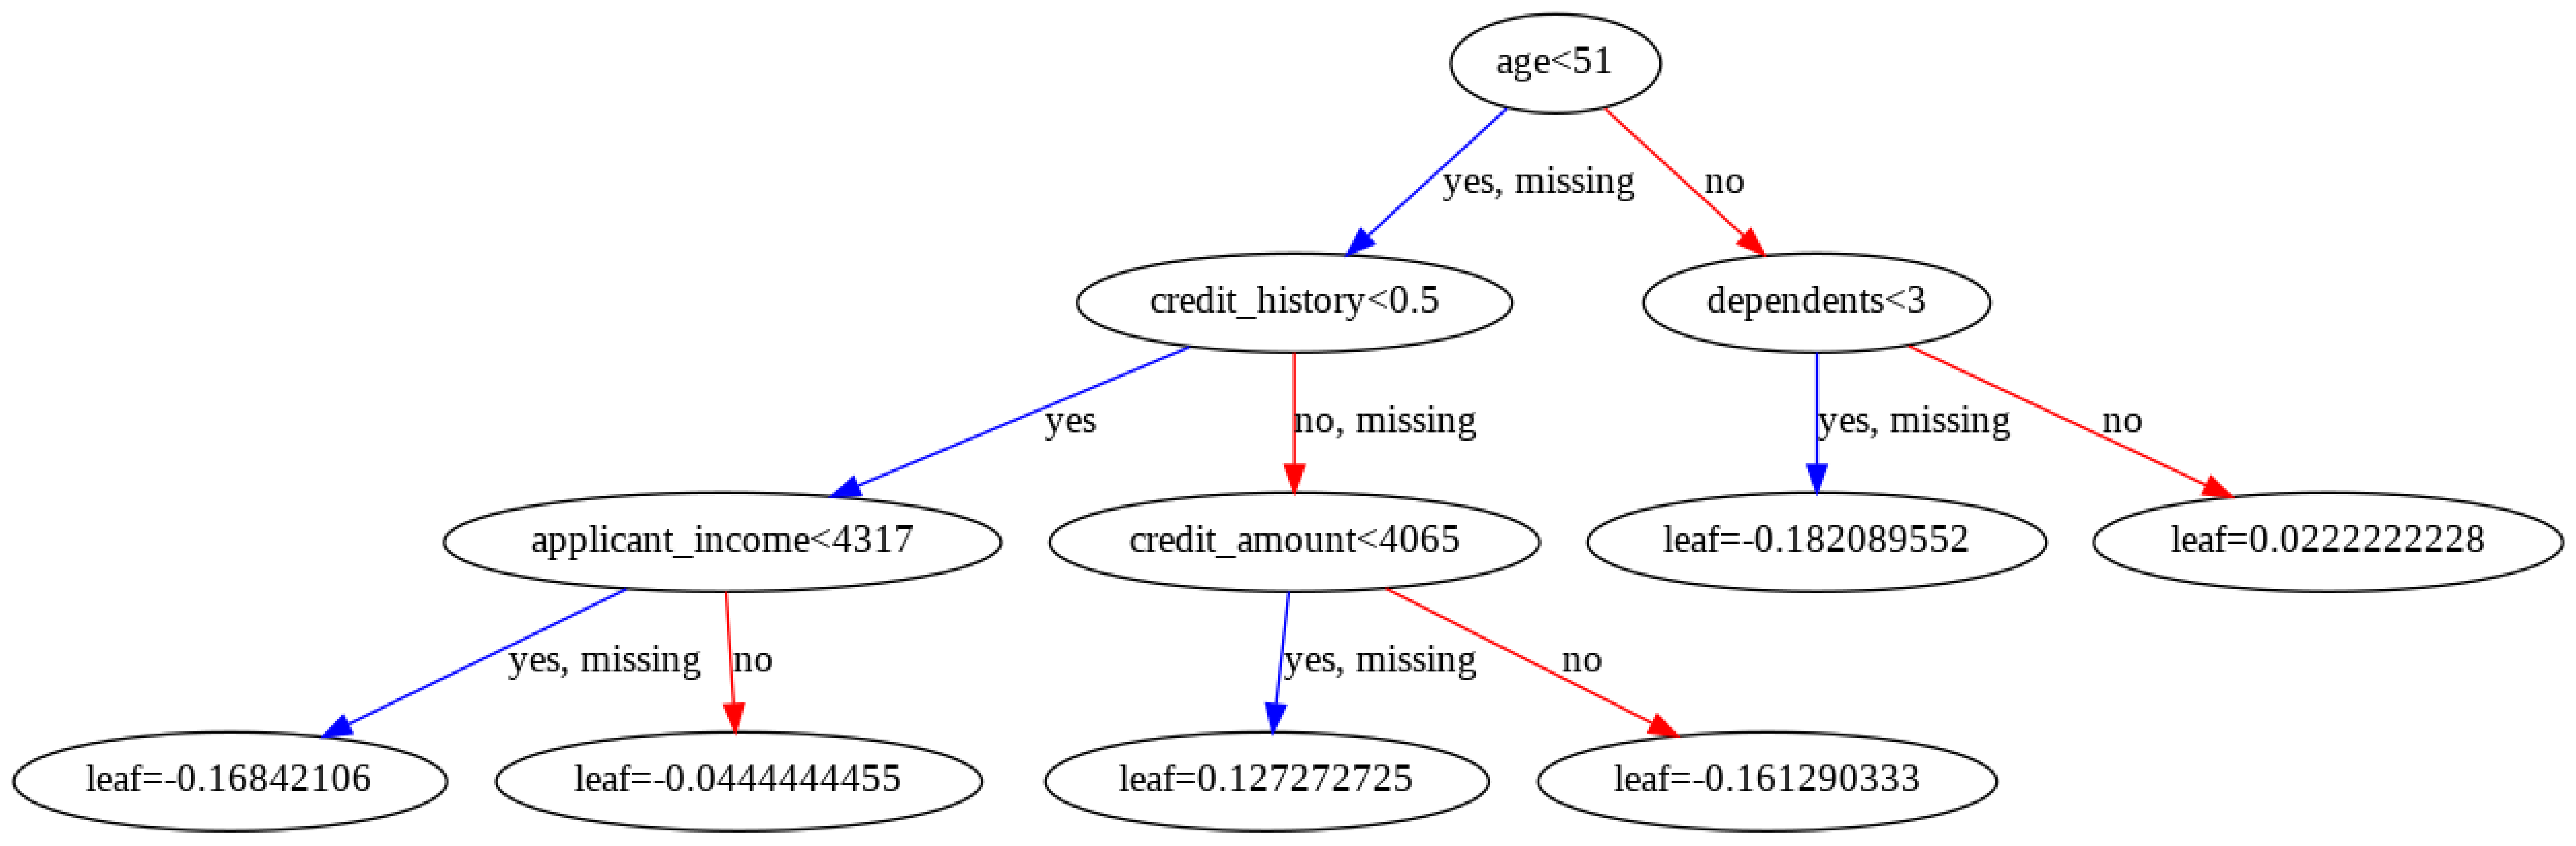

In [41]:
%matplotlib inline
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

import matplotlib.pyplot as plt

from xgboost import plot_tree
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 100,200

plot_tree(model)
plt.show()